In [98]:
# plot color
# https://matplotlib.org/stable/gallery/color/named_colors.html

# cv
# https://coding-potato.tistory.com/15
# https://jimmy-ai.tistory.com/178

# feature importance
# https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/

# set_axis
# https://stackoverflow.com/questions/39132181/dataframe-set-index-from-list

# plt, ax
# https://m.blog.naver.com/allieverwanted/222146678032

# Import Dataset and Libraries

In [2]:
from typing import Any
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings(action='ignore')
plt.rc('font', family='Malgun Gothic')

In [100]:
preprocess_file = "./preprocessing.csv"

drop_columns = [
    'index',
    'date',
    'round',#
#    'game_count',
#    'game_goal',
#    'cur_game_count',
    'win_odds',#
    'lose_odds',#
    'track_E',
#    'cc',
#    'part_people',
#    'rank',
    'prefix_rank',#
    'odds_result',
    'significant',
#    'RESULT',
#    'track_E_encoded',
    'odds_result_SU',#
    'odds_result_UD',#
]

df_pp = pd.read_csv(preprocess_file)
df_pp = df_pp.drop(drop_columns, axis=1)

In [101]:
df_pp.head()

,game_count,game_goal,cur_game_count,cc,part_people,rank,RESULT,track_E_encoded
0,3,15,1,150,10,10,False,41
1,3,15,2,150,12,7,False,20
2,3,15,1,150,11,2,True,41
3,3,15,2,150,11,5,True,0
4,3,15,3,150,12,5,True,18


In [102]:
df_pp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 620 entries, 0 to 619
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   game_count       620 non-null    int64
 1   game_goal        620 non-null    int64
 2   cur_game_count   620 non-null    int64
 3   cc               620 non-null    int64
 4   part_people      620 non-null    int64
 5   rank             620 non-null    int64
 6   RESULT           620 non-null    bool 
 7   track_E_encoded  620 non-null    int64
dtypes: bool(1), int64(7)
memory usage: 34.6 KB


# Modeling Data Subset

In [103]:
X = df_pp
X, y_rank, y_result = X.drop(['rank', 'RESULT'], axis=1), X['rank'], X['RESULT'].astype(bool)

In [104]:
X.head()

,game_count,game_goal,cur_game_count,cc,part_people,track_E_encoded
0,3,15,1,150,10,41
1,3,15,2,150,12,20
2,3,15,1,150,11,41
3,3,15,2,150,11,0
4,3,15,3,150,12,18


# Modeling

In [105]:
!python --version

Python 3.11.5


In [106]:
# !python.exe -m pip install --upgrade pip
# !pip install scikit-learn
# !pip install xgboost
# !pip install lightgbm
# !pip install catboost

In [9]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import hamming_loss
from sklearn.metrics import jaccard_score
from sklearn.base import BaseEstimator

# Classification Model Import
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# Regression Model Import
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

In [10]:
clf_model_dict = {
    "clf_ridge": LogisticRegression(penalty='l2', solver='lbfgs'),
    "clf_lasso": LogisticRegression(penalty='l1', solver='liblinear'),
    "clf_logistic_regression": LogisticRegression(),
    "clf_logistic_regression_": LogisticRegression(solver='liblinear'),
    "clf_adaboost": AdaBoostClassifier(),
    "clf_gradient_boosting": GradientBoostingClassifier(),
    "clf_random_forest": RandomForestClassifier(),
    "clf_xgb": XGBClassifier(),
    "clf_xgb_": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
#     "clf_lgbm": LGBMClassifier() > 성능 문제로 인한 제외
    "clf_catboost": CatBoostClassifier(verbose=0),
    "clf_decision_tree": DecisionTreeClassifier(),
#    "clf_svc": SVC(probability = True) > 성능 문제로 인한 제외
}

reg_model_dict = {
    "reg_ridge": Ridge(),
    "reg_lasso": Lasso(),
    "reg_linear_regression": LinearRegression(),
    "reg_adaboost": AdaBoostRegressor(),
    "reg_gradient_boosting": GradientBoostingRegressor(),
    "reg_random_forest": RandomForestRegressor(),
    "reg_xgb": XGBRegressor(),
#    "reg_lgbm": LGBMRegressor() > 성능 문제로 인한 제외
    "reg_catboost": CatBoostRegressor(verbose=0),
    "reg_decision_tree": DecisionTreeRegressor(),
    "reg_svr": SVR(),
}

# Training Model

In [109]:
from sklearn.model_selection import train_test_split


def fit_model(
    model: BaseEstimator,
    X: pd.DataFrame,
    y: pd.Series,
    test_size: float = 0.2,
    random_state: int = 42
) -> tuple[BaseEstimator, pd.DataFrame, pd.Series, pd.DataFrame, pd.Series]:

    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size = test_size,
        random_state = random_state
    )
    model.fit(X_train, y_train)
    
    return model, X_train, X_test, y_train, y_test

# Evaluate Model

## Classification

In [110]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
)


def eval_clf_model(model: BaseEstimator, X: pd.DataFrame, y: pd.Series) -> tuple[float]:
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:, 1]

    # is CatBoostClassifier
    if isinstance(y_pred[0], str):
        accuracy = accuracy_score(y, y_pred)                        # 정확도
        precision = precision_score(y, y_pred, pos_label='True')    # 정밀도
        recall = recall_score(y, y_pred, pos_label='True')          # 재현율
        f1 = f1_score(y, y_pred, pos_label='True')                  # F1 점수
        roc_auc = roc_auc_score(y, y_proba)                         # ROC-AUC 점수
        
    else:
        accuracy = accuracy_score(y, y_pred)      # 정확도
        precision = precision_score(y, y_pred)    # 정밀도
        recall = recall_score(y, y_pred)          # 재현율
        f1 = f1_score(y, y_pred)                  # F1 점수
        roc_auc = roc_auc_score(y, y_proba)       # ROC-AUC 점수
    
    return accuracy, precision, recall, f1, roc_auc

## Regression

In [111]:
from sklearn.metrics import (
    r2_score, mean_absolute_error, mean_squared_error
)


def eval_reg_model(model: BaseEstimator, X: pd.DataFrame, y: pd.Series) -> tuple[float]:
    y_pred = model.predict(X)

    r2 = r2_score(y, y_pred)                # R² 점수
    mae = mean_absolute_error(y, y_pred)    # 평균 절대 오차 (MAE)
    mse = mean_squared_error(y, y_pred)     # 평균 제곱 오차 (MSE)
    rmse = mean_squared_error(y, y_pred, squared=False)    # 평균 제곱근 오차 (RMSE)

    return r2, mae, mse, rmse

# K-Fold Cross Validation

In [112]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

from collections import defaultdict

## Classification

In [113]:
# cross_val_score의 estimator가 classifier 종류이면 내부적으로 stratified KFold 로 진행
def clf_cross_validation(
    model: BaseEstimator,
    X: pd.DataFrame,
    y: pd.Series,
    cv: int = 5
) -> tuple[list[float]]:
    
    # No1 cv
    scores1 = dict()
    scores1['cvs_acc'] = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
    scores1['cvs_pre'] = cross_val_score(model, X, y, cv=cv, scoring='precision')
    scores1['cvs_rec'] = cross_val_score(model, X, y, cv=cv, scoring='recall')
    scores1['cvs_f1 '] = cross_val_score(model, X, y, cv=cv, scoring='f1')
    scores1['cvs_roc'] = cross_val_score(model, X, y, cv=cv, scoring='roc_auc')

    # No2 cv    
    scores2 = dict()
    skfolds = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)
    scores2['mix_acc'] = cross_val_score(model, X, y, cv=skfolds, scoring='accuracy')
    scores2['mix_pre'] = cross_val_score(model, X, y, cv=skfolds, scoring='precision')
    scores2['mix_rec'] = cross_val_score(model, X, y, cv=skfolds, scoring='recall')
    scores2['mix_f1 '] = cross_val_score(model, X, y, cv=skfolds, scoring='f1')
    scores2['mix_roc'] = cross_val_score(model, X, y, cv=skfolds, scoring='roc_auc')
    
    # No3 cv
    scores3 = defaultdict(list)
    for fold_idx, (train_idx, val_idx) in enumerate(skfolds.split(X, y)):
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
        
        model.fit(X_train, y_train)
        scores = eval_clf_model(model, X_val, y_val)
        accuracy, precision, recall, f1, roc_auc = scores
        
        scores3['skf_acc'].append(accuracy)
        scores3['skf_pre'].append(precision)
        scores3['skf_rec'].append(recall)
        scores3['skf_f1 '].append(f1)
        scores3['skf_roc'].append(roc_auc)
    
    return scores1,scores2, scores3

In [114]:
from sklearn.metrics import make_scorer
   

# cross_val_score의 estimator가 classifier 종류이면 내부적으로 stratified KFold 로 진행
def clf_catboost_cross_validation(
    model: BaseEstimator,
    X: pd.DataFrame,
    y: pd.Series,
    cv: int = 5
) -> tuple[list[float]]:
    
    # No1 cv
    scores1 = dict()
    scores1['cvs_acc'] = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
    scorer = make_scorer(precision_score, pos_label='True')
    scores1['cvs_pre'] = cross_val_score(model, X, y, cv=cv, scoring=scorer)
    scorer = make_scorer(recall_score, pos_label='True')
    scores1['cvs_rec'] = cross_val_score(model, X, y, cv=cv, scoring=scorer)
    scorer = make_scorer(f1_score, pos_label='True')
    scores1['cvs_f1 '] = cross_val_score(model, X, y, cv=cv, scoring=scorer)
    scores1['cvs_roc'] = cross_val_score(model, X, y, cv=cv, scoring='roc_auc')

    # No2 cv    
    scores2 = dict()
    skfolds = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)
    scores2['mix_acc'] = cross_val_score(model, X, y, cv=skfolds, scoring='accuracy')
    scorer = make_scorer(precision_score, pos_label='True')
    scores2['mix_pre'] = cross_val_score(model, X, y, cv=skfolds, scoring=scorer)
    scorer = make_scorer(recall_score, pos_label='True')
    scores2['mix_rec'] = cross_val_score(model, X, y, cv=skfolds, scoring=scorer)
    scorer = make_scorer(f1_score, pos_label='True')
    scores2['mix_f1 '] = cross_val_score(model, X, y, cv=skfolds, scoring=scorer)
    scores2['mix_roc'] = cross_val_score(model, X, y, cv=skfolds, scoring='roc_auc')
    
    # No3 cv
    scores3 = defaultdict(list)
    for fold_idx, (train_idx, val_idx) in enumerate(skfolds.split(X, y)):
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
        
        model.fit(X_train, y_train)
        scores = eval_clf_model(model, X_val, y_val)
        accuracy, precision, recall, f1, roc_auc = scores
        
        scores3['skf_acc'].append(accuracy)
        scores3['skf_pre'].append(precision)
        scores3['skf_rec'].append(recall)
        scores3['skf_f1 '].append(f1)
        scores3['skf_roc'].append(roc_auc)
    
    return scores1,scores2, scores3

### Print Classification Cross-Validation Score

In [115]:
def print_clf_score(
    model: BaseEstimator,
    scores1: dict,
    scores2: dict,
    scores3: dict
) -> None:
       
    # Scores1: cross_val_score
    for key, value in scores1.items():
        print(f'{key}: {np.mean(value)}')

    # Scores2: StratifiedKFold by cross_val_score
    for key, value in scores2.items():
        print(f'{key}: {np.mean(value)}')

    # Scores3: StratifiedKFold score
    for key, value in scores3.items():
        print(f'{key}: {np.mean(value)}')

## clf 모델 점수 평가

In [116]:
df_clf_scores = pd.DataFrame()
Y = y_result
k = 5

for model_name, model in tqdm(clf_model_dict.items()):    
    model, X_train, X_test, y_train, y_test = fit_model(model, X, Y)
    
    # is CatBoostClassifier
    if model_name == "clf_catboost":
        scores1, scores2, scores3 = clf_catboost_cross_validation(
            model,
            X_test,
            y_test.astype(str),
            k
        )
        
    else:
        scores1, scores2, scores3 = clf_cross_validation(
            model,
            X_test,
            y_test,
            k
        )
    
    # print_clf_score(model, scores1, scores2, scores3)
    values = (
        [np.mean(s) for s in scores1.values()] + 
        [np.mean(s) for s in scores2.values()] + 
        [np.mean(s) for s in scores3.values()]
    )    
    
    df_tmp = pd.DataFrame({model_name: values})
    df_clf_scores = pd.concat([df_clf_scores, df_tmp], axis=1)
    
keys = [k for k in scores1.keys()] + [k for k in scores2.keys()] + [k for k in scores3.keys()]
df_clf_scores = pd.concat([df_clf_scores, pd.DataFrame({"name":keys})], axis=1)
df_clf_scores

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [01:20<00:00,  7.30s/it]


,clf_ridge,clf_lasso,clf_logistic_regression,clf_logistic_regression_,clf_adaboost,clf_gradient_boosting,clf_random_forest,clf_xgb,clf_xgb_,clf_catboost,clf_decision_tree,name
0,0.653333,0.661000,0.653333,0.669333,0.637000,0.613667,0.645000,0.612333,0.612333,0.694333,0.581333,cvs_acc
1,0.550952,0.485714,0.550952,0.505714,0.527778,0.553022,0.433974,0.451667,0.451667,0.633333,0.414048,cvs_pre
2,0.266667,0.333333,0.266667,0.333333,0.377778,0.377778,0.400000,0.400000,0.400000,0.288889,0.511111,cvs_rec
3,0.349817,0.391538,0.349817,0.397253,0.425742,0.388797,0.385378,0.413519,0.413519,0.387646,0.432807,cvs_f1
4,0.652917,0.681806,0.652917,0.684954,0.572407,0.556435,0.621157,0.565046,0.565046,0.573102,0.549722,cvs_roc
5,0.670000,0.694333,0.670000,0.694333,0.573000,0.589667,0.622000,0.581333,0.581333,0.622333,0.596333,mix_acc
6,0.597143,0.595000,0.597143,0.595000,0.393333,0.353810,0.518413,0.416270,0.416270,0.373333,0.435354,mix_pre
7,0.311111,0.377778,0.311111,0.377778,0.355556,0.244444,0.377778,0.333333,0.333333,0.177778,0.400000,mix_rec
8,0.400649,0.446784,0.400649,0.446784,0.369825,0.285363,0.405864,0.362682,0.362682,0.231602,0.471173,mix_f1
9,0.642361,0.643380,0.642361,0.648935,0.567731,0.530417,0.579861,0.539583,0.539583,0.555139,0.610231,mix_roc


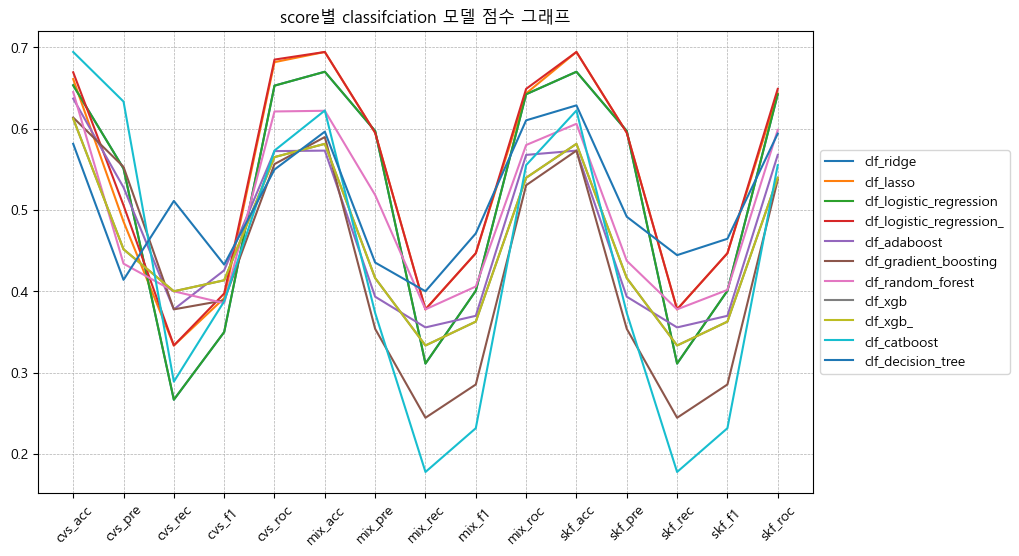

In [117]:
# https://stackoverflow.com/questions/26358200/xticks-by-pandas-plot-rename-with-the-string

df_clf_scores.plot(
    title = "score별 classifciation 모델 점수 그래프",
    figsize = (10, 6),
    rot = 45
).set_xticks(df_clf_scores.index, df_clf_scores.name)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True, linestyle='--', linewidth=0.5, axis='x')
plt.grid(True, linestyle='--', linewidth=0.5, axis='y')

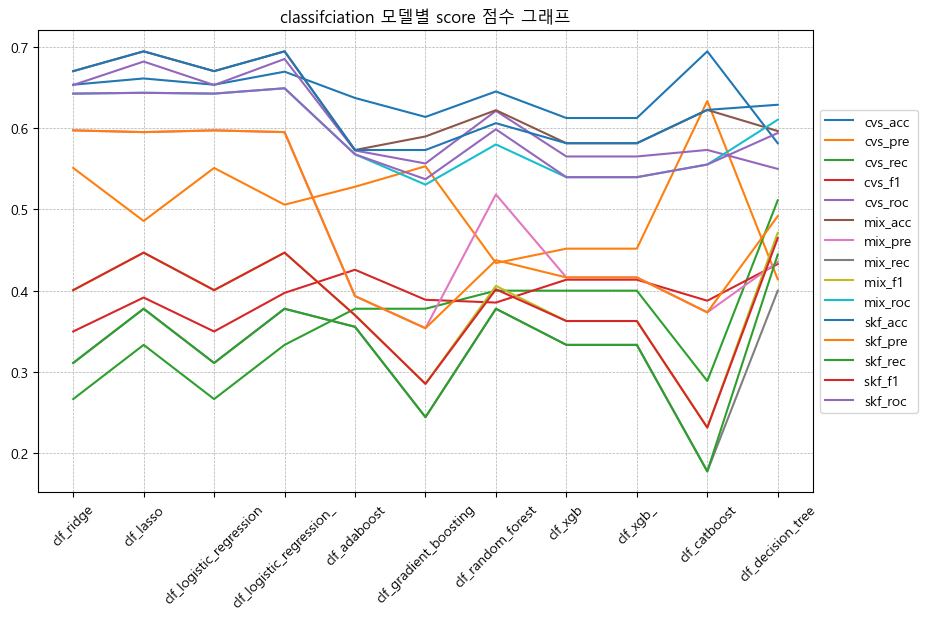

In [118]:
# https://stackoverflow.com/questions/42381639/how-do-i-transpose-dataframe-in-pandas-without-index
# https://stackoverflow.com/questions/20107570/removing-index-column-in-pandas-when-reading-a-csv

df_clf_scores.set_index('name').T.plot(
    title = "classifciation 모델별 score 점수 그래프",
    figsize = (10, 6),
    rot = 45
).set_xticks(range(11), df_clf_scores.set_index('name').T.index)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True, linestyle='--', linewidth=0.5, axis='x')
plt.grid(True, linestyle='--', linewidth=0.5, axis='y')

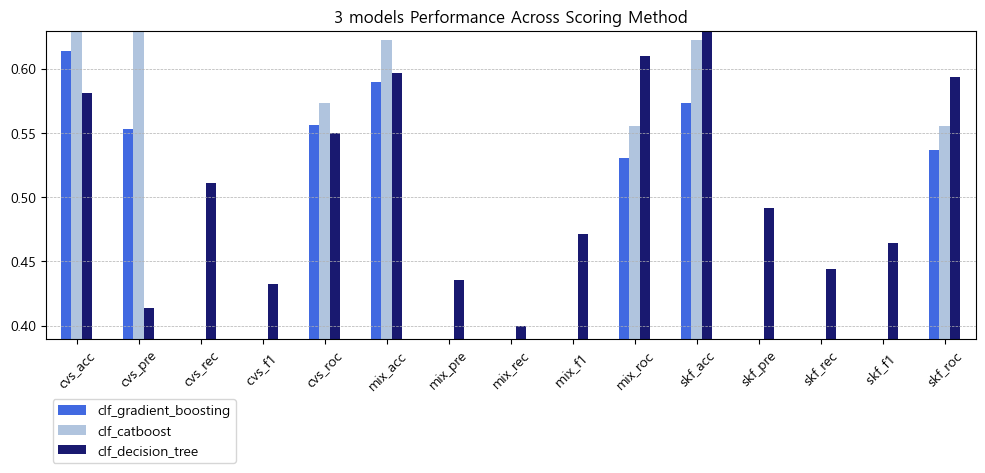

In [119]:
df_tmp = df_clf_scores[[
    "clf_gradient_boosting",
    "clf_catboost",
    "clf_decision_tree",
    "name"
]]

df_tmp.set_index('name').plot.bar(
    figsize = (12, 4),
    title= f"{len(df_tmp.columns)-1} models Performance Across Scoring Method",
    color = ['royalblue', 'lightsteelblue', 'midnightblue', ],
    xlabel = "",
    ylabel = "",
    ylim = [min(df_tmp["clf_decision_tree"])-0.01, max(df_tmp["clf_decision_tree"])+0.001],
    rot = 45
)

plt.legend(loc='center left', bbox_to_anchor=(0, -0.3))
plt.grid(True, linestyle='--', linewidth=0.5, axis='y')

## Regression

In [120]:
def reg_cross_validation(
    model: BaseEstimator,
    X: pd.DataFrame,
    y: pd.Series,
    cv: int = 5
) -> tuple[list[float]]:
    
    # No1 cv
    scores1 = dict()
    scores1['cvs_r2'] = cross_val_score(model, X, y, cv=cv, scoring='r2')
    scores1['cvs_mae'] = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_absolute_error')
    scores1['cvs_mse'] = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error')
    scores1['cvs_rmse'] = cross_val_score(model, X, y, cv=cv, scoring='neg_root_mean_squared_error')

    # No2 cv    
    scores2 = dict()
    skfolds = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)
    scores2['mix_r2'] = cross_val_score(model, X, y, cv=skfolds, scoring='r2')
    scores2['mix_mae'] = cross_val_score(model, X, y, cv=skfolds, scoring='neg_mean_absolute_error')
    scores2['mix_mse'] = cross_val_score(model, X, y, cv=skfolds, scoring='neg_mean_squared_error')
    scores2['mix_rmse'] = cross_val_score(model, X, y, cv=skfolds, scoring='neg_root_mean_squared_error')
    
    # No3 cv
    scores3 = defaultdict(list)
    for fold_idx, (train_idx, val_idx) in enumerate(skfolds.split(X, y)):
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]

        model.fit(X_train, y_train)
        scores = eval_reg_model(model, X_val, y_val)
        r2, mae, mse, rmse = scores
        
        scores3['skf_r2'].append(r2)
        scores3['skf_mae'].append(mae)
        scores3['skf_mse'].append(mse)
        scores3['skf_rmse'].append(rmse)
    
    return scores1,scores2, scores3

### Print Regression Cross-Validation Score

In [121]:
def print_reg_score(
    model: BaseEstimator,
    scores1: dict(),
    scores2: dict(),
    scores3: dict()
) -> None:    
    # Scores1: cross_val_score
    for key, value in scores1.items():
        print(f'{key}: {np.mean(value)}')

    # Scores2: StratifiedKFold by cross_val_score
    for key, value in scores2.items():
        print(f'{key}: {np.mean(value)}')

    # Scores3: StratifiedKFold score
    for key, value in scores3.items():
        print(f'{key}: {np.mean(value)}')

## reg 모델 점수 평가

In [122]:
df_reg_scores = pd.DataFrame()
Y = y_rank
k = 5

for model_name, model in tqdm(reg_model_dict.items()):
    model, X_train, X_test, y_train, y_test = fit_model(model, X, Y)    
    scores1,scores2, scores3 = reg_cross_validation(
        model,
        X_test,
        y_test,
        k
    )
    
    # print_reg_score(model, scores1, scores2, socres3)
    values = (
        [abs(np.mean(s)) for s in scores1.values()] + 
        [abs(np.mean(s)) for s in scores2.values()] + 
        [abs(np.mean(s)) for s in scores3.values()]
    )    
    
    df_tmp = pd.DataFrame({model_name: values})
    df_reg_scores = pd.concat([df_reg_scores, df_tmp], axis=1)
    
keys = [k for k in scores1.keys()] + [k for k in scores2.keys()] + [k for k in scores3.keys()]
df_reg_scores = pd.concat([df_reg_scores, pd.DataFrame({"name":keys})], axis=1)
df_reg_scores

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:39<00:00,  3.92s/it]


,reg_ridge,reg_lasso,reg_linear_regression,reg_adaboost,reg_gradient_boosting,reg_random_forest,reg_xgb,reg_catboost,reg_decision_tree,reg_svr,name
0,0.030468,0.061659,0.028804,0.099570,0.234269,0.218427,0.589161,0.387006,1.014330,0.130597,cvs_r2
1,2.599372,2.771947,2.600111,2.616576,2.832824,2.782656,3.137127,2.987589,3.628333,2.859029,cvs_mae
2,9.303790,10.225568,9.324813,9.815798,11.805076,11.450636,14.712286,13.150949,18.942333,10.865231,cvs_mse
3,3.042487,3.187326,3.045562,3.175140,3.437500,3.331967,3.816327,3.619455,4.364140,3.285291,cvs_rmse
4,0.100853,0.010775,0.100475,0.012106,0.126112,0.096128,0.391769,0.257751,0.776006,0.073204,mix_r2
5,2.576408,2.733085,2.570094,2.759184,2.801639,2.715990,2.975051,2.896227,3.439000,2.836884,mix_mae
6,9.001168,9.884237,9.004455,9.613108,11.524186,11.068006,13.920222,12.641952,17.944333,10.707784,mix_mse
7,2.987033,3.142438,2.987593,3.143526,3.376238,3.291193,3.703068,3.530353,4.189642,3.270917,mix_rmse
8,0.100853,0.010775,0.100475,0.003417,0.153406,0.095804,0.391769,0.257751,0.822301,0.073204,skf_r2
9,2.576408,2.733085,2.570094,2.719526,2.818490,2.764775,2.975051,2.896227,3.358667,2.836884,skf_mae


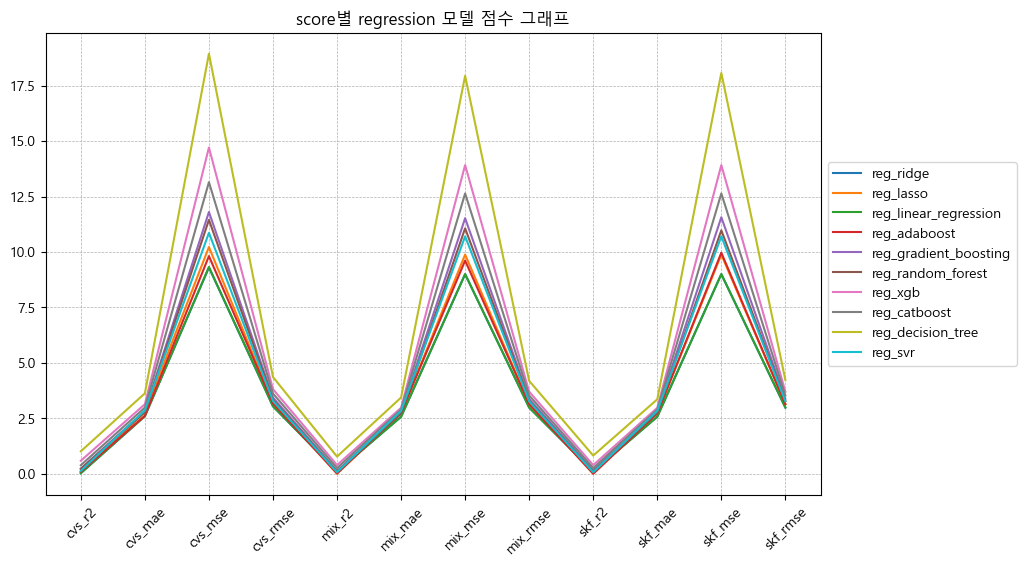

In [123]:
df_reg_scores.plot(
    title = "score별 regression 모델 점수 그래프",
    figsize = (10, 6),
    rot = 45
).set_xticks(df_reg_scores.index, df_reg_scores.name)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True, linestyle='--', linewidth=0.5, axis='x')
plt.grid(True, linestyle='--', linewidth=0.5, axis='y')

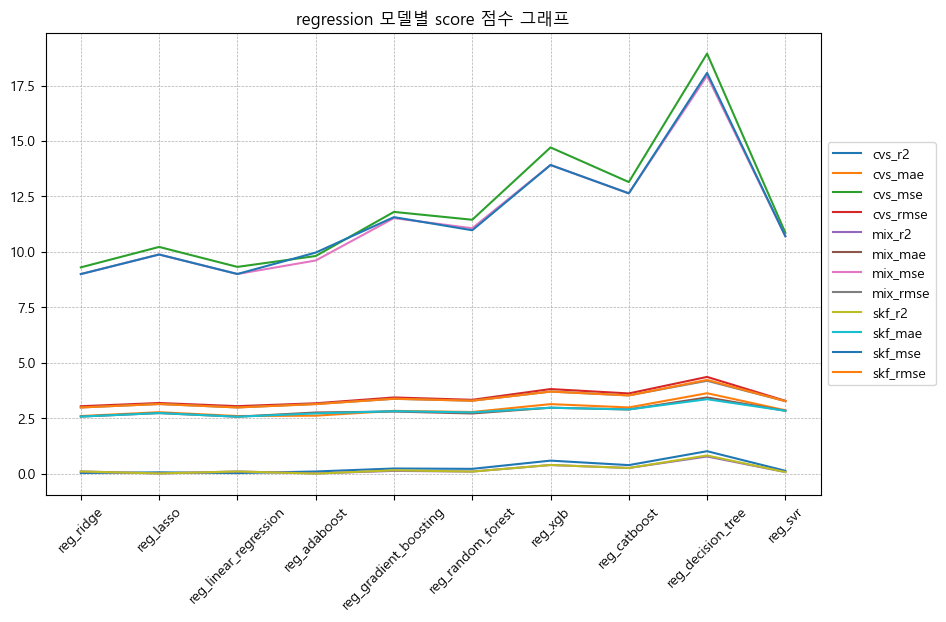

In [124]:
df_reg_scores.set_index('name').T.plot(
    title = "regression 모델별 score 점수 그래프",
    figsize = (10, 6),
    rot = 45
).set_xticks(range(10), df_reg_scores.set_index('name').T.index)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True, linestyle='--', linewidth=0.5, axis='x')
plt.grid(True, linestyle='--', linewidth=0.5, axis='y')

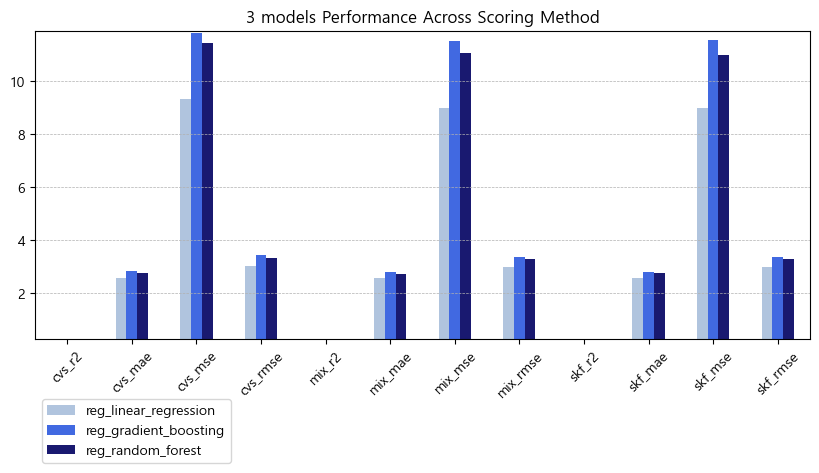

In [125]:
df_tmp = df_reg_scores[[
    "reg_linear_regression",
    "reg_gradient_boosting",
    "reg_random_forest",
    "name"
]]

df_tmp.set_index('name').plot.bar(
    figsize = (10, 4),
    title= f"{len(df_tmp.columns)-1} models Performance Across Scoring Method",
    color = ['lightsteelblue', 'royalblue', 'midnightblue', ],
    xlabel = "",
    ylabel = "",
    ylim = [0.3, max(df_tmp["reg_gradient_boosting"])+0.1],
    rot = 45
)

plt.legend(loc='center left', bbox_to_anchor=(0, -0.3))
plt.grid(True, linestyle='--', linewidth=0.5, axis='y')

# Test model

In [126]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder


def preprocessing(df: pd.DataFrame) -> pd.DataFrame:
    # track_E
    label_encoder = LabelEncoder()
    encoded = label_encoder.fit_transform(df['track_E'])
    df['track_E_encoded'] = encoded
    
    # odds_result
    df['odds_result'] = df['odds_result'].replace("straight up", "SU").replace("underdog", "UD")
    encoder = OneHotEncoder(sparse=False)
    encoded = encoder.fit_transform(df[['odds_result']])
    df_encoded = pd.DataFrame(encoded.astype(int), columns=encoder.get_feature_names_out())
    df = pd.concat([df.reset_index(), df_encoded], axis=1)
    
    return df

In [127]:
drop_columns = [
     'level_0',
     'index',
     'date',
     'round',
#     'game_count',
#     'game_goal',
#     'cur_game_count',
     'win_odds',
     'lose_odds',
     'track_K',
     'track_E',
#     'cc',
#     'part_people',
     'rank',
     'prefix_rank',
     'odds_result',
     'significant',
     'RESULT',
#     'track_E_encoded',
     'odds_result_SU',
     'odds_result_UD',
]

remain_columns = [
        'round', 'game_count', 'game_goal', 'cur_game_count', 'win_odds', 'lose_odds',
        'cc', 'part_people', 'prefix_rank', 'track_E_encoded', 'odds_result_SU', 'odds_result_UD',
]

remain_columns = [
        'game_count', 'game_goal', 'cur_game_count',
        'cc', 'part_people', 'track_E_encoded',
]

df_test = pd.read_csv("./data/test240227_ver315.csv")
df_test = pd.read_csv("./data/test240227_ver320.csv")
df_test = preprocessing(df_test)
df_test_X, df_test_y_result, df_test_y_rank = (
    df_test.drop(drop_columns, axis=1),
    df_test['RESULT'],
    df_test['rank']
)

pp_clf_model1 = clf_model_dict['clf_gradient_boosting'].fit(X, y_result)
pp_clf_model2 = clf_model_dict['clf_decision_tree'].fit(X, y_result)
y_pred1 = pp_clf_model1.predict_proba(df_test_X)
y_pred2 = pp_clf_model2.predict_proba(df_test_X)
# accuracy = accuracy_score(df_test_y_result, y_pred)
    
pp_reg_model1 = reg_model_dict['reg_gradient_boosting'].fit(X, y_rank)
pp_reg_model2 = reg_model_dict['reg_random_forest'].fit(X, y_rank)
y_pred1 = pp_reg_model1.predict(df_test_X)
y_pred2 = pp_reg_model2.predict(df_test_X)
# accuracy = mean_absolute_error(df_test_y_rank, y_pred)
for l, g, y in zip(y_pred1, y_pred2, df_test_y_rank):
    print(round(l), round(g), "--", y)

7 6 -- 11
10 10 -- 12
6 6 -- 10
8 8 -- 10
8 7 -- 2
8 8 -- 12
7 7 -- 10
8 7 -- 7
7 9 -- 11
7 6 -- 5
9 7 -- 10
8 8 -- 3
9 9 -- 7
6 3 -- 11
8 8 -- 8
8 7 -- 8
8 8 -- 6
9 9 -- 8
9 9 -- 2
8 8 -- 4
9 10 -- 10
9 9 -- 4
5 3 -- 3
9 10 -- 12
6 6 -- 4
6 4 -- 6
4 3 -- 8


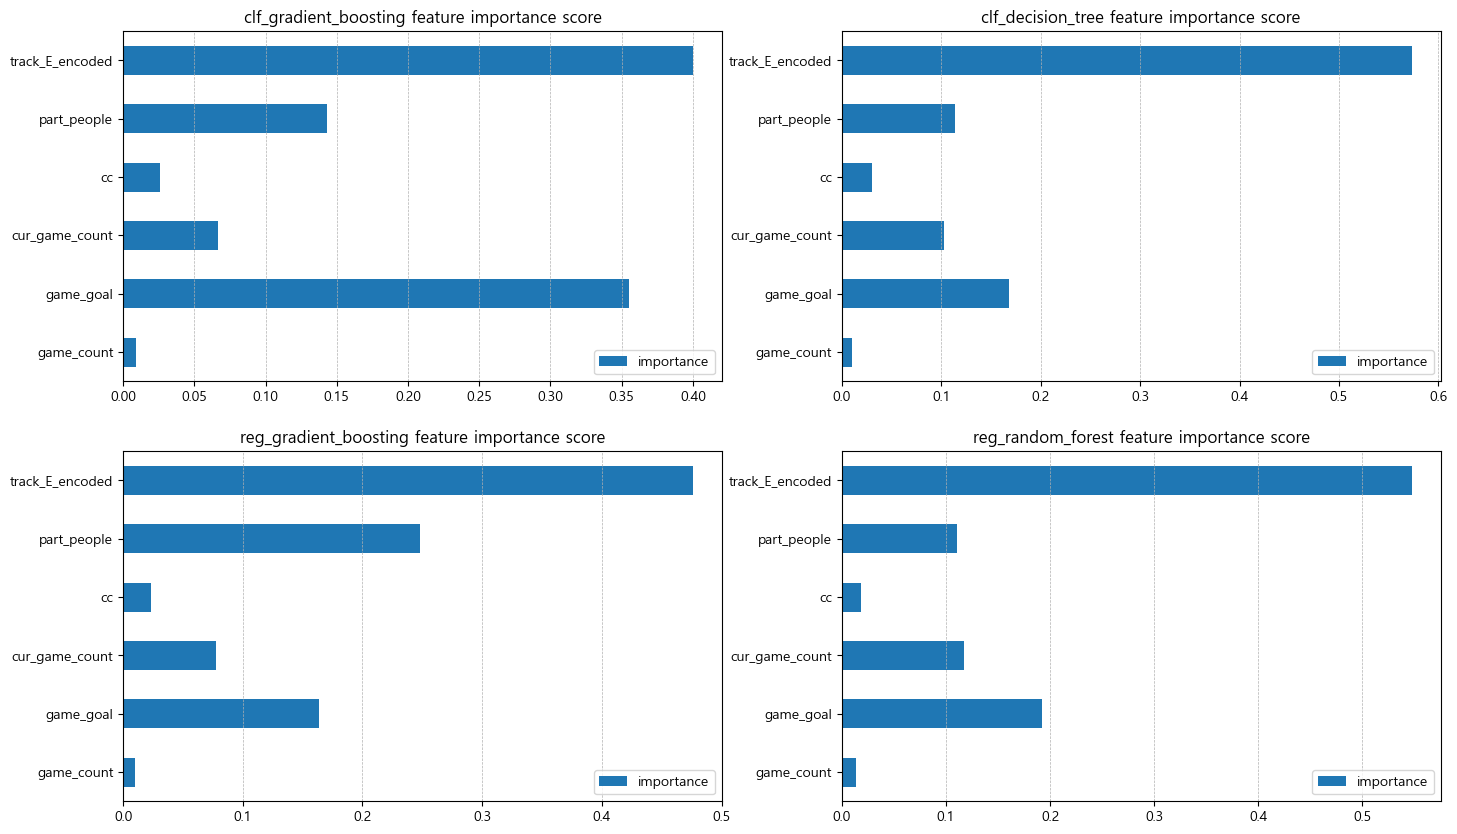

In [128]:
fig, axs = plt.subplots(2, 2, figsize=(17, 10))

# clf_1
pd.DataFrame({
    "importance": pp_clf_model1.feature_importances_,
}).set_axis(remain_columns).plot.barh(
    ax = axs[0][0],
    title = "clf_gradient_boosting feature importance score",
)
axs[0][0].grid(True, linestyle='--', linewidth=0.5, axis='x')

# clf_2
pd.DataFrame({
    "importance": pp_clf_model2.feature_importances_,
}).set_axis(remain_columns).plot.barh(
    ax = axs[0][1],
    title = "clf_decision_tree feature importance score",
)
axs[0][1].grid(True, linestyle='--', linewidth=0.5, axis='x')

# reg_1
pd.DataFrame({
    "importance": pp_reg_model1.feature_importances_,
}).set_axis(remain_columns).plot.barh(
    ax = axs[1][0],
    title = "reg_gradient_boosting feature importance score",
)
axs[1][0].grid(True, linestyle='--', linewidth=0.5, axis='x')

# reg_2
pd.DataFrame({
    "importance": pp_reg_model2.feature_importances_,
}).set_axis(remain_columns).plot.barh(
    ax = axs[1][1],
    title = "reg_random_forest feature importance score",
)
axs[1][1].grid(True, linestyle='--', linewidth=0.5, axis='x')

# Conclusion

## 불안전한 놀이터 성공/실패: 분류(Classification) 문제
### 최종 선정 모델 3개
### 1순위: Gradient Boosting
### 2순위: Deicision Tree, CatBoost

## 불안전한 놀이터 순위 예측: 회귀(Regression) 문제
### 최종 선정 모델 2개
### 1순위: Random Forest
### 2순위: Gradient Boosting

In [153]:
# 'track_E' 컬럼을 원-핫 인코딩
ohe = OneHotEncoder()
track_E_encoded = ohe.fit_transform(X[['track_E_encoded']]).toarray()

# 인코딩된 데이터를 DataFrame으로 변환
df_track_E_encoded = pd.DataFrame(
    track_E_encoded,
    columns = ohe.get_feature_names_out(['track_E_encoded'])
)

# 인코딩된 데이터를 원래 데이터셋에 합치고 'track_E' 컬럼은 제거
df_encoded = pd.concat([X, df_track_E_encoded], axis=1)

# ------------------------------------------------------------------------------------------------

df_clf_scores = pd.DataFrame()
Y = y_result
k = 5

for model_name, model in tqdm(clf_model_dict.items()):    
    model, X_train, X_test, y_train, y_test = fit_model(model, df_encoded, Y)
    
    # is CatBoostClassifier
    if model_name == "clf_catboost":
        scores1, scores2, scores3 = clf_catboost_cross_validation(
            model,
            X_test,
            y_test.astype(str),
            k
        )
        
    else:
        scores1, scores2, scores3 = clf_cross_validation(
            model,
            X_test,
            y_test,
            k
        )
    
    # print_clf_score(model, scores1, scores2, scores3)
    values = (
        [np.mean(s) for s in scores1.values()] + 
        [np.mean(s) for s in scores2.values()] + 
        [np.mean(s) for s in scores3.values()]
    )    
    
    df_tmp = pd.DataFrame({model_name: values})
    df_clf_scores = pd.concat([df_clf_scores, df_tmp], axis=1)
    
keys = [k for k in scores1.keys()] + [k for k in scores2.keys()] + [k for k in scores3.keys()]
df_clf_scores = pd.concat([df_clf_scores, pd.DataFrame({"name":keys})], axis=1)
df_clf_scores

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [01:41<00:00,  9.23s/it]


,clf_ridge,clf_lasso,clf_logistic_regression,clf_logistic_regression_,clf_adaboost,clf_gradient_boosting,clf_random_forest,clf_xgb,clf_xgb_,clf_catboost,clf_decision_tree,name
0,0.645000,0.669333,0.645000,0.637000,0.580333,0.614000,0.653667,0.612333,0.612333,0.678000,0.597333,cvs_acc
1,0.433333,0.505714,0.433333,0.422222,0.393333,0.506667,0.486667,0.451667,0.451667,0.453333,0.475714,cvs_pre
2,0.266667,0.333333,0.266667,0.266667,0.355556,0.244444,0.155556,0.400000,0.400000,0.177778,0.311111,cvs_rec
3,0.322323,0.397253,0.322323,0.317094,0.352994,0.317316,0.247619,0.413519,0.413519,0.252381,0.334286,cvs_f1
4,0.631991,0.670602,0.631991,0.630509,0.478148,0.560417,0.532778,0.565046,0.565046,0.556157,0.540833,cvs_roc
5,0.636667,0.686000,0.636667,0.653000,0.589000,0.532333,0.596667,0.581333,0.581333,0.605333,0.597000,mix_acc
6,0.492381,0.651190,0.492381,0.523333,0.386032,0.321905,0.410952,0.416270,0.416270,0.466667,0.387778,mix_pre
7,0.355556,0.377778,0.355556,0.355556,0.377778,0.200000,0.200000,0.333333,0.333333,0.111111,0.288889,mix_rec
8,0.397689,0.436373,0.397689,0.410532,0.377987,0.223388,0.191235,0.362682,0.362682,0.169697,0.272407,mix_f1
9,0.606991,0.642083,0.606991,0.604306,0.494352,0.512454,0.508056,0.539583,0.539583,0.506435,0.525926,mix_roc


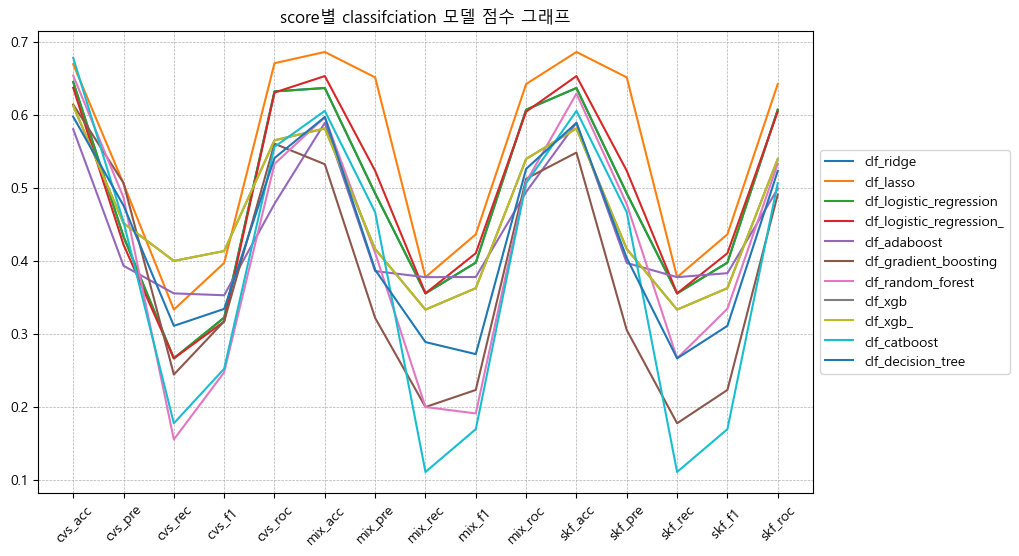

In [154]:
# https://stackoverflow.com/questions/26358200/xticks-by-pandas-plot-rename-with-the-string

df_clf_scores.plot(
    title = "score별 classifciation 모델 점수 그래프",
    figsize = (10, 6),
    rot = 45
).set_xticks(df_clf_scores.index, df_clf_scores.name)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True, linestyle='--', linewidth=0.5, axis='x')
plt.grid(True, linestyle='--', linewidth=0.5, axis='y')

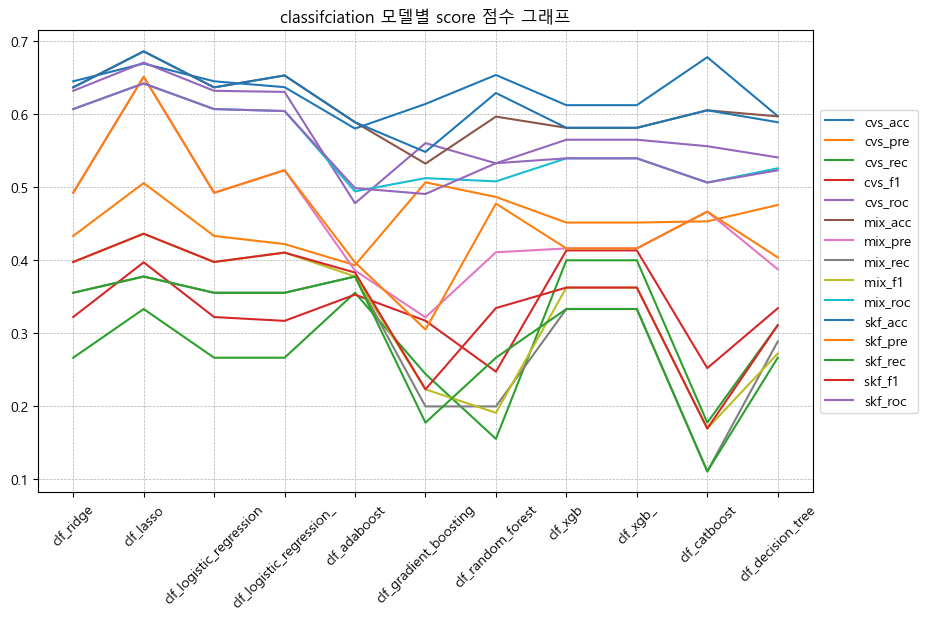

In [155]:
# https://stackoverflow.com/questions/42381639/how-do-i-transpose-dataframe-in-pandas-without-index
# https://stackoverflow.com/questions/20107570/removing-index-column-in-pandas-when-reading-a-csv

df_clf_scores.set_index('name').T.plot(
    title = "classifciation 모델별 score 점수 그래프",
    figsize = (10, 6),
    rot = 45
).set_xticks(range(11), df_clf_scores.set_index('name').T.index)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True, linestyle='--', linewidth=0.5, axis='x')
plt.grid(True, linestyle='--', linewidth=0.5, axis='y')

In [156]:
df_reg_scores = pd.DataFrame()
Y = y_rank
k = 5

for model_name, model in tqdm(reg_model_dict.items()):
    model, X_train, X_test, y_train, y_test = fit_model(model, df_encoded, Y)    
    scores1,scores2, scores3 = reg_cross_validation(
        model,
        X_test,
        y_test,
        k
    )
    
    # print_reg_score(model, scores1, scores2, socres3)
    values = (
        [abs(np.mean(s)) for s in scores1.values()] + 
        [abs(np.mean(s)) for s in scores2.values()] + 
        [abs(np.mean(s)) for s in scores3.values()]
    )    
    
    df_tmp = pd.DataFrame({model_name: values})
    df_reg_scores = pd.concat([df_reg_scores, df_tmp], axis=1)
    
keys = [k for k in scores1.keys()] + [k for k in scores2.keys()] + [k for k in scores3.keys()]
df_reg_scores = pd.concat([df_reg_scores, pd.DataFrame({"name":keys})], axis=1)
df_reg_scores

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:54<00:00,  5.44s/it]


,reg_ridge,reg_lasso,reg_linear_regression,reg_adaboost,reg_gradient_boosting,reg_random_forest,reg_xgb,reg_catboost,reg_decision_tree,reg_svr,name
0,0.047028,0.061659,6.890191e+19,0.043989,0.067694,0.072431,0.387248,0.138484,0.503865,0.118940,cvs_r2
1,2.526482,2.771947,6.916786e+09,2.807648,2.687150,2.681661,2.902584,2.748772,3.116000,2.831488,cvs_mae
2,9.082635,10.225568,5.081224e+20,10.109042,10.064762,10.448014,13.237141,10.777624,15.408000,10.751371,cvs_mse
3,3.007935,3.187326,1.450283e+10,3.093189,3.166594,3.229464,3.621999,3.277503,3.988635,3.269065,cvs_rmse
4,0.097558,0.010775,1.657247e+21,0.112949,0.054183,0.016298,0.331813,0.070501,0.587580,0.068229,mix_r2
5,2.545035,2.733085,5.151288e+10,2.627663,2.619698,2.658201,2.954991,2.747074,3.198000,2.826100,mix_mae
6,9.031250,9.884237,1.593722e+22,9.587791,9.351096,10.255671,13.389660,10.762848,15.231000,10.659175,mix_mse
7,2.996895,3.142438,1.006941e+11,3.206410,3.040567,3.158125,3.622718,3.256232,4.027044,3.263503,mix_rmse
8,0.097558,0.010775,1.657247e+21,0.066354,0.045054,0.029375,0.331813,0.070501,0.670461,0.068229,skf_r2
9,2.545035,2.733085,5.151288e+10,2.589578,2.630552,2.668948,2.954991,2.747074,3.237333,2.826100,skf_mae


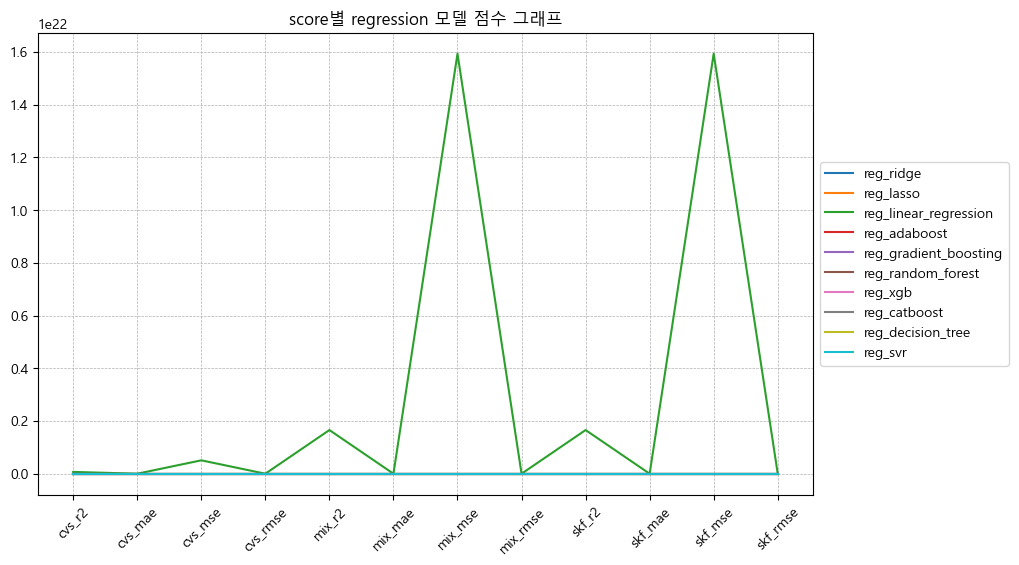

In [157]:
df_reg_scores.plot(
    title = "score별 regression 모델 점수 그래프",
    figsize = (10, 6),
    rot = 45
).set_xticks(df_reg_scores.index, df_reg_scores.name)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True, linestyle='--', linewidth=0.5, axis='x')
plt.grid(True, linestyle='--', linewidth=0.5, axis='y')

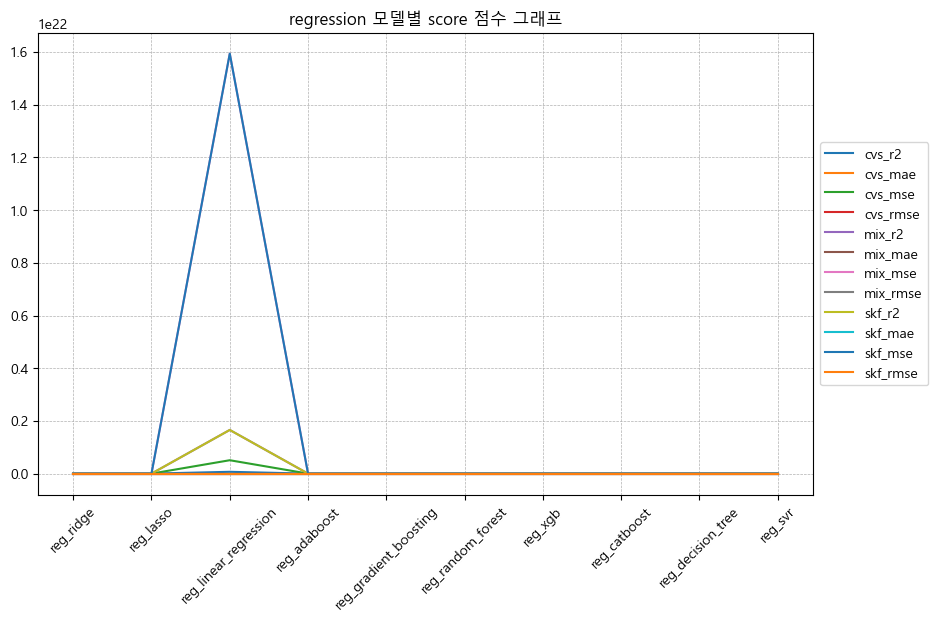

In [158]:
df_reg_scores.set_index('name').T.plot(
    title = "regression 모델별 score 점수 그래프",
    figsize = (10, 6),
    rot = 45
).set_xticks(range(10), df_reg_scores.set_index('name').T.index)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True, linestyle='--', linewidth=0.5, axis='x')
plt.grid(True, linestyle='--', linewidth=0.5, axis='y')

In [207]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 'track_E' 컬럼을 원-핫 인코딩
ohe = OneHotEncoder()
track_E_encoded = ohe.fit_transform(X[['track_E_encoded']]).toarray()

# 인코딩된 데이터를 DataFrame으로 변환
df_track_E_encoded = pd.DataFrame(
    track_E_encoded,
    columns = ohe.get_feature_names_out(['track_E_encoded'])
)

# 데이터 표준화
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_track_E_encoded)

# PCA 변경
N = 3
pca = PCA(n_components = N)
pca_result = pca.fit_transform(scaled_data)

# DataFrame으로 변환
df_pca = pd.DataFrame(pca_result, columns=["PCA"+str(i) for i in range(1, N+1)])

# 인코딩된 데이터를 원래 데이터셋에 합치고 'track_E' 컬럼은 제거
df_encoded = pd.concat([X, df_pca], axis=1)

# ------------------------------------------------------------------------------------------------

df_clf_scores = pd.DataFrame()
Y = y_result
k = 5

for model_name, model in tqdm(clf_model_dict.items()):    
    model, X_train, X_test, y_train, y_test = fit_model(model, df_encoded, Y)
    
    # is CatBoostClassifier
    if model_name == "clf_catboost":
        scores1, scores2, scores3 = clf_catboost_cross_validation(
            model,
            X_test,
            y_test.astype(str),
            k
        )
        
    else:
        scores1, scores2, scores3 = clf_cross_validation(
            model,
            X_test,
            y_test,
            k
        )
    
    # print_clf_score(model, scores1, scores2, scores3)
    values = (
        [np.mean(s) for s in scores1.values()] + 
        [np.mean(s) for s in scores2.values()] + 
        [np.mean(s) for s in scores3.values()]
    )    
    
    df_tmp = pd.DataFrame({model_name: values})
    df_clf_scores = pd.concat([df_clf_scores, df_tmp], axis=1)
    
keys = [k for k in scores1.keys()] + [k for k in scores2.keys()] + [k for k in scores3.keys()]
df_clf_scores = pd.concat([df_clf_scores, pd.DataFrame({"name":keys})], axis=1)
df_clf_scores

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [01:28<00:00,  8.05s/it]


,clf_ridge,clf_lasso,clf_logistic_regression,clf_logistic_regression_,clf_adaboost,clf_gradient_boosting,clf_random_forest,clf_xgb,clf_xgb_,clf_catboost,clf_decision_tree,name
0,0.644333,0.652333,0.644333,0.652333,0.605000,0.597000,0.605333,0.588667,0.588667,0.654000,0.589333,cvs_acc
1,0.451429,0.455000,0.451429,0.455000,0.458889,0.316667,0.500000,0.360556,0.360556,0.460000,0.362381,cvs_pre
2,0.311111,0.333333,0.311111,0.333333,0.355556,0.266667,0.200000,0.288889,0.288889,0.244444,0.222222,cvs_rec
3,0.367143,0.381849,0.367143,0.381849,0.395780,0.305671,0.310795,0.317012,0.317012,0.310649,0.319658,cvs_f1
4,0.648056,0.642315,0.648056,0.643796,0.554583,0.541528,0.593426,0.573981,0.573981,0.612176,0.510694,cvs_roc
5,0.678000,0.654000,0.678000,0.678000,0.555667,0.556333,0.588333,0.548333,0.548333,0.621000,0.525000,mix_acc
6,0.653333,0.621905,0.653333,0.653333,0.408889,0.375000,0.396905,0.293333,0.293333,0.483333,0.263333,mix_pre
7,0.355556,0.311111,0.355556,0.355556,0.377778,0.266667,0.200000,0.222222,0.222222,0.177778,0.333333,mix_rec
8,0.414035,0.374158,0.414035,0.414035,0.385129,0.307563,0.260989,0.248020,0.248020,0.250163,0.305928,mix_f1
9,0.608472,0.613426,0.608472,0.607778,0.528750,0.454120,0.477917,0.448657,0.448657,0.500602,0.454444,mix_roc


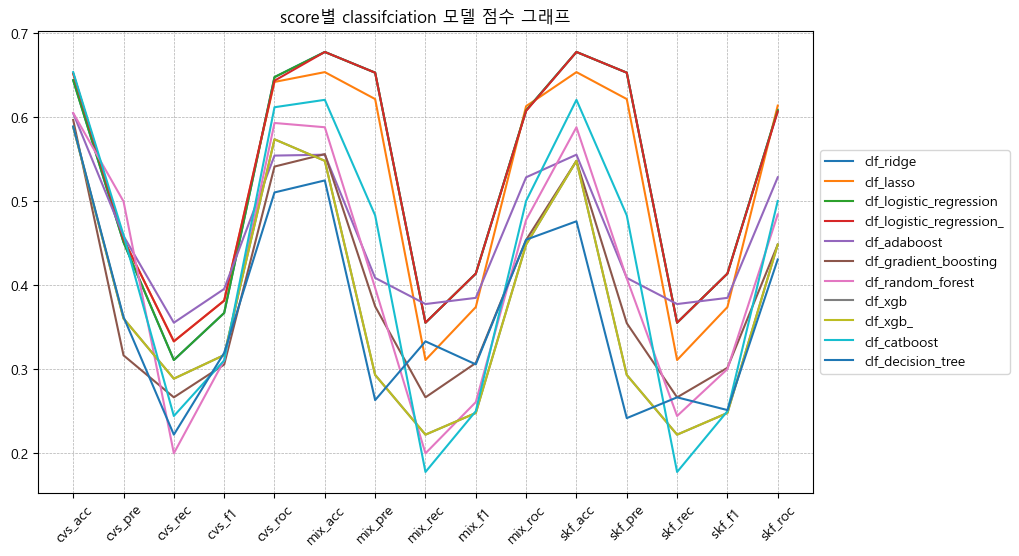

In [208]:
# https://stackoverflow.com/questions/26358200/xticks-by-pandas-plot-rename-with-the-string

df_clf_scores.plot(
    title = "score별 classifciation 모델 점수 그래프",
    figsize = (10, 6),
    rot = 45
).set_xticks(df_clf_scores.index, df_clf_scores.name)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True, linestyle='--', linewidth=0.5, axis='x')
plt.grid(True, linestyle='--', linewidth=0.5, axis='y')

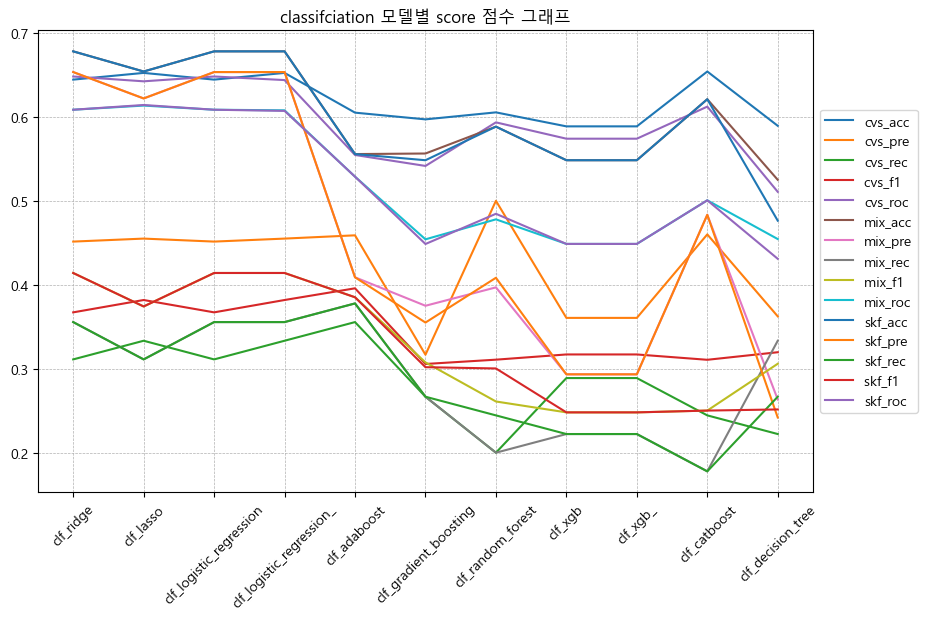

In [209]:
# https://stackoverflow.com/questions/42381639/how-do-i-transpose-dataframe-in-pandas-without-index
# https://stackoverflow.com/questions/20107570/removing-index-column-in-pandas-when-reading-a-csv

df_clf_scores.set_index('name').T.plot(
    title = "classifciation 모델별 score 점수 그래프",
    figsize = (10, 6),
    rot = 45
).set_xticks(range(11), df_clf_scores.set_index('name').T.index)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True, linestyle='--', linewidth=0.5, axis='x')
plt.grid(True, linestyle='--', linewidth=0.5, axis='y')

In [210]:
df_reg_scores = pd.DataFrame()
Y = y_rank
k = 5

for model_name, model in tqdm(reg_model_dict.items()):
    model, X_train, X_test, y_train, y_test = fit_model(model, df_encoded, Y)    
    scores1,scores2, scores3 = reg_cross_validation(
        model,
        X_test,
        y_test,
        k
    )
    
    # print_reg_score(model, scores1, scores2, socres3)
    values = (
        [abs(np.mean(s)) for s in scores1.values()] + 
        [abs(np.mean(s)) for s in scores2.values()] + 
        [abs(np.mean(s)) for s in scores3.values()]
    )    
    
    df_tmp = pd.DataFrame({model_name: values})
    df_reg_scores = pd.concat([df_reg_scores, df_tmp], axis=1)
    
keys = [k for k in scores1.keys()] + [k for k in scores2.keys()] + [k for k in scores3.keys()]
df_reg_scores = pd.concat([df_reg_scores, pd.DataFrame({"name":keys})], axis=1)
df_reg_scores

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:45<00:00,  4.50s/it]


,reg_ridge,reg_lasso,reg_linear_regression,reg_adaboost,reg_gradient_boosting,reg_random_forest,reg_xgb,reg_catboost,reg_decision_tree,reg_svr,name
0,0.087739,0.061659,0.085226,0.063263,0.038582,0.062704,0.178507,0.047024,0.645489,0.125004,cvs_r2
1,2.519114,2.771947,2.521501,2.584903,2.486293,2.555319,2.691862,2.583582,3.079000,2.847225,cvs_mae
2,8.756225,10.225568,8.785444,9.150898,9.230641,9.044124,11.138318,10.025495,15.709444,10.810391,cvs_mse
3,2.951063,3.187326,2.955807,3.065580,3.018193,3.012187,3.334598,3.159564,3.979733,3.277587,cvs_rmse
4,0.147965,0.010775,0.147521,0.053928,0.067701,0.021105,0.337622,0.089765,0.621518,0.069983,mix_r2
5,2.474257,2.733085,2.467928,2.600292,2.678791,2.638961,2.881104,2.764859,3.176222,2.830795,mix_mae
6,8.498830,9.884237,8.502492,9.262562,10.656503,9.905882,13.349237,10.925368,17.246000,10.676503,mix_mse
7,2.901169,3.142438,2.901689,2.999230,3.261185,3.139220,3.645270,3.298384,3.932152,3.266129,mix_rmse
8,0.147965,0.010775,0.147521,0.101327,0.075382,0.006165,0.337622,0.089765,0.718271,0.069983,skf_r2
9,2.474257,2.733085,2.467928,2.542287,2.690044,2.686313,2.881104,2.764859,3.255556,2.830795,skf_mae


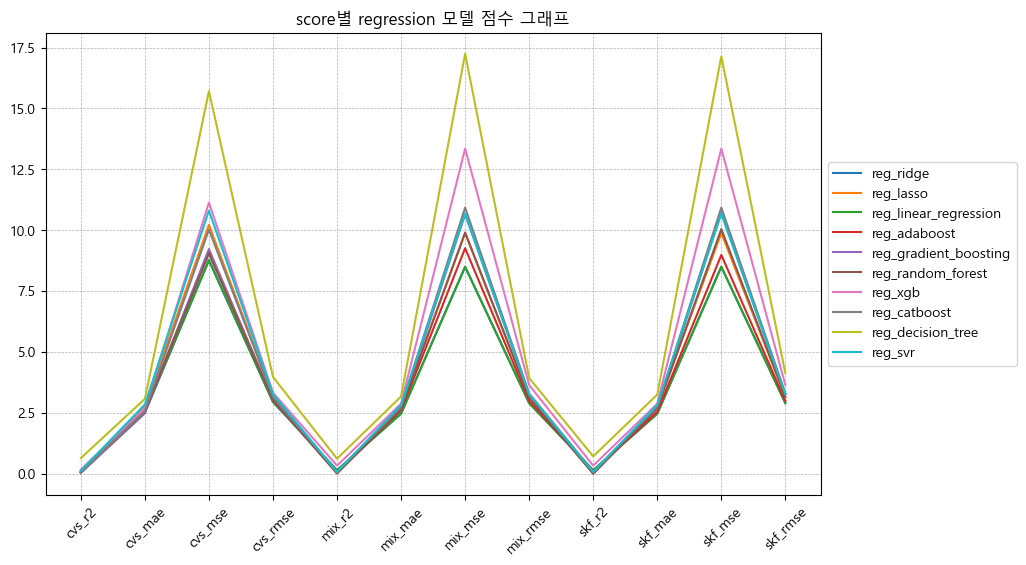

In [211]:
df_reg_scores.plot(
    title = "score별 regression 모델 점수 그래프",
    figsize = (10, 6),
    rot = 45
).set_xticks(df_reg_scores.index, df_reg_scores.name)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True, linestyle='--', linewidth=0.5, axis='x')
plt.grid(True, linestyle='--', linewidth=0.5, axis='y')

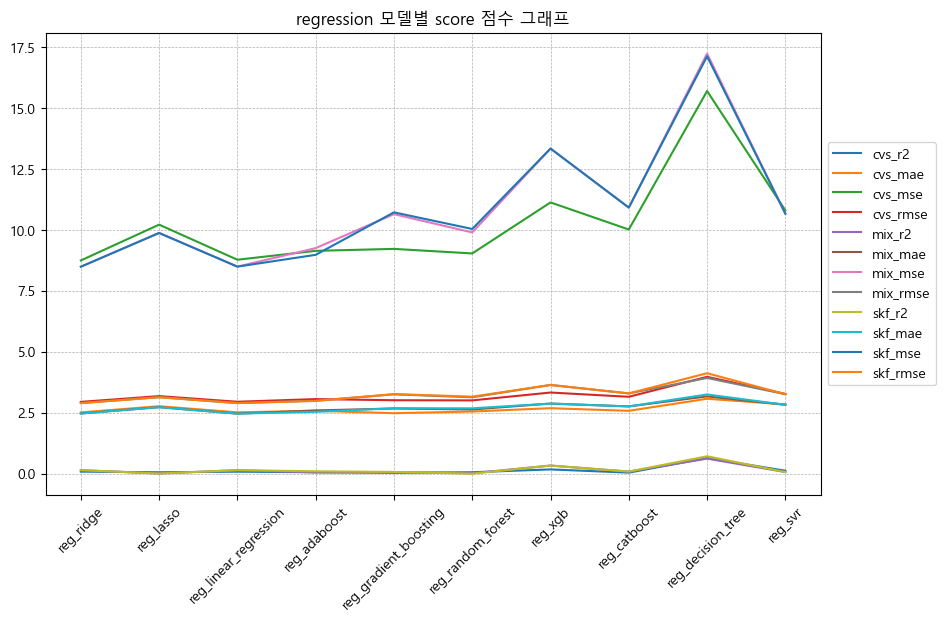

In [212]:
df_reg_scores.set_index('name').T.plot(
    title = "regression 모델별 score 점수 그래프",
    figsize = (10, 6),
    rot = 45
).set_xticks(range(10), df_reg_scores.set_index('name').T.index)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True, linestyle='--', linewidth=0.5, axis='x')
plt.grid(True, linestyle='--', linewidth=0.5, axis='y')

In [284]:
def preprocessing(df: pd.DataFrame) -> pd.DataFrame:
    # track_E
    label_encoder = LabelEncoder()
    encoded = label_encoder.fit_transform(df['track_E'])
    df['track_E_encoded'] = encoded
    
    # odds_result
    df['odds_result'] = df['odds_result'].replace("straight up", "SU").replace("underdog", "UD")
    encoder = OneHotEncoder(sparse=False)
    encoded = encoder.fit_transform(df[['odds_result']])
    df_encoded = pd.DataFrame(encoded.astype(int), columns=encoder.get_feature_names_out())
    df = pd.concat([df.reset_index(), df_encoded], axis=1)
    
    # track_E
    ohe = OneHotEncoder()
    scaler = StandardScaler()
    df_track_E_encoded = pd.DataFrame(
        ohe.fit_transform(df[['track_E_encoded']]).toarray(),
        columns = ohe.get_feature_names_out(['track_E_encoded'])
    )
    
    N = 3
    pca = PCA(n_components = N)
    df_pca = pd.DataFrame(
        # pca.fit_transform(scaler.fit_transform(df_track_E_encoded)),
        pca.fit_transform(df_track_E_encoded),
        columns=["PCA"+str(i) for i in range(1, N+1)]
    )
    df = pd.concat([df.drop('track_E_encoded', axis=1), df_pca], axis=1)
    
    return df

In [11]:
drop_columns = [
     'index',
     'date',
     'round',
#     'game_count',
#     'game_goal',
#     'cur_game_count',
     'win_odds',
     'lose_odds',
     'track_K',
     'track_E',
#     'cc',
#     'part_people',
     'rank',
     'prefix_rank',
     'odds_result',
     'significant',
     'RESULT',
#     'track_E_encoded',
#     'odds_result_SU',
#     'odds_result_UD',
]

remain_columns = [
        'game_count', 'game_goal', 'cur_game_count',
        'cc', 'part_people',
]

df_test = pd.read_csv("./data/test240227_ver315.csv")
df_test = pd.read_csv("./data/test240227_ver320.csv")

# df_test = preprocessing(df_test)
df_test_X, df_test_y_result, df_test_y_rank = (
    df_test.drop(drop_columns, axis=1),
    df_test['RESULT'],
    df_test['rank']
)

# model = clf_model_dict['clf_lasso']
# pp_clf_model1 = model.fit(df_encoded.drop('track_E_encoded', axis=1), y_result)
# y_clf_pred1 = pp_clf_model1.predict(df_test_X)

# model = clf_model_dict['clf_logistic_regression']
# pp_clf_model2 = model.fit(df_encoded.drop('track_E_encoded', axis=1), y_result)
# y_clf_pred2 = pp_clf_model2.predict(df_test_X)


# model = reg_model_dict['reg_linear_regression']
# pp_reg_model1 = model.fit(df_encoded.drop('track_E_encoded', axis=1), y_rank)
# y_reg_pred1 = pp_reg_model1.predict(df_test_X)

# model = reg_model_dict['reg_adaboost']
# pp_reg_model2 = model.fit(df_encoded.drop('track_E_encoded', axis=1), y_rank)
# y_reg_pred2 = pp_reg_model2.predict(df_test_X)

model = reg_model_dict['reg_linear_regression']
pp_reg_model1 = model.fit(df_test_X, y_rank)
y_reg_pred1 = pp_reg_model1.predict(df_test_X)

model = reg_model_dict['reg_adaboost']
pp_reg_model2 = model.fit(df_test_X, y_rank)
y_reg_pred2 = pp_reg_model2.predict(df_test_X)

for l, g, y in zip(y_reg_pred1, y_reg_pred2, df_test_y_rank):
    print(round(l), round(g), "--", y)

NameError: name 'y_rank' is not defined

In [319]:
track_2_num = {'3DS DK Jungle': 0,
 '3DS Music Park': 1,
 '3DS Neo Bowser City': 2,
 '3DS Piranha Plant Slide': 3,
 '3DS Rainbow Road': 4,
 '3DS Rock Rock Mountain': 5,
 '3DS Toad Circuit': 6,
 'Animal Crossing': 7,
 'Big Blue': 8,
 'Bone Dry Dunes': 9,
 "Bowser's Castle": 10,
 'Cloudtop Cruise': 11,
 'DS Cheep Cheep Beach': 12,
 'DS Mario Circuit': 13,
 'DS Peach Gardens': 14,
 'DS Shroom Ridge': 15,
 'DS Tick Tock Clock': 16,
 'DS Walluigi Pinball': 17,
 'DS Wario Stardium': 18,
 'Dolphin Shoals': 19,
 'Dragon Driftway': 20,
 'Electrodrome': 21,
 'Excitebike Arena': 22,
 'GBA Boo Lake': 23,
 'GBA Cheese Land': 24,
 'GBA Mario Circuit': 25,
 'GBA Ribbon Road': 26,
 'GBA Riverside Park': 27,
 'GBA Sky Garden': 28,
 'GBA Snow Land': 29,
 'GBA Sunset Wilds': 30,
 'GC Baby Park': 31,
 'GC DK Mountain': 32,
 'GC Dry Dry Desert': 33,
 'GC Sherbet Land': 34,
 'GC Waluigi Stadium': 35,
 "GC Yoshi's Circuit": 36,
 'Hyrule Circuit': 37,
 'Ice Ice Outpost': 38,
 'Mario Circuit': 39,
 'Mario Kart Stadium': 40,
 'Mount Wario': 41,
 'Mute City': 42,
 'N64 Choco Mountain': 43,
 'N64 Kalimari Desert': 44,
 'N64 Rainbow Road': 45,
 'N64 Royal Raceway': 46,
 "N64 Toad's Turnpike": 47,
 'N64 Yoshi Valley': 48,
 'Rainbow Road': 49,
 'SFC Bowser Castle 3': 50,
 'SFC Dount Plains 3': 51,
 'SFC Mario Circuit 3': 52,
 'SFC Raindow Road': 53,
 'Shy Guy Falls': 54,
 'Sky-High Sundae': 55,
 'Squeaky Clean Sprint': 56,
 'Sunshine Airport': 57,
 'Super Bell Subway': 58,
 'Sweet Sweet Canyon': 59,
 'Thwomp Ruins': 60,
 'Toad Harbor': 61,
 'Tour Amsterdam Drift': 62,
 'Tour Athens Dash': 63,
 'Tour Bangkok Rush': 64,
 'Tour Berlin Byways': 65,
 'Tour London Loop': 66,
 'Tour Los Angeles Laps': 67,
 'Tour Madrid Drive': 68,
 'Tour Merry Mountain': 69,
 'Tour New York Minute': 70,
 'Tour Ninja Hideway': 71,
 'Tour Paris Promenade': 72,
 'Tour Rome Avanti': 73,
 'Tour Singapore Speedway': 74,
 'Tour Sydney Sprint': 75,
 'Tour Tokyo Blur': 76,
 'Tour Vancouver Velocity': 77,
 'Twisted Mansion': 78,
 'Water Park': 79,
 'Wii Coconut Mall': 80,
 'Wii DK Summit': 81,
 'Wii Grumble Volcano': 82,
 'Wii Koopa Cape': 83,
 'Wii Maple Treeway': 84,
 'Wii Moo Moo Meadows': 85,
 'Wii Mushroom Gorge': 86,
 'Wii Rainbow Road': 87,
 "Wii Wario's Gold Mine": 88,
 'Wild Woods': 89,
 "Yoshi's Island": 90}


def track_2_PCA(track):
    data = [0] * 91
    data[track] = 1
    
    df_data = pd.DataFrame(data)
    
    return pca.transform(df_data.T)[0]

t = 23
dummy = [[3, 15, 1, 150, 12] + list(track_2_PCA(t))]
p = (
    pp_clf_model1.predict(dummy),
    pp_clf_model2.predict(dummy),
    pp_reg_model1.predict(dummy),
    pp_reg_model2.predict(dummy),
)
p

(array([False]), array([False]), array([6.80827394]), array([6.92070485]))

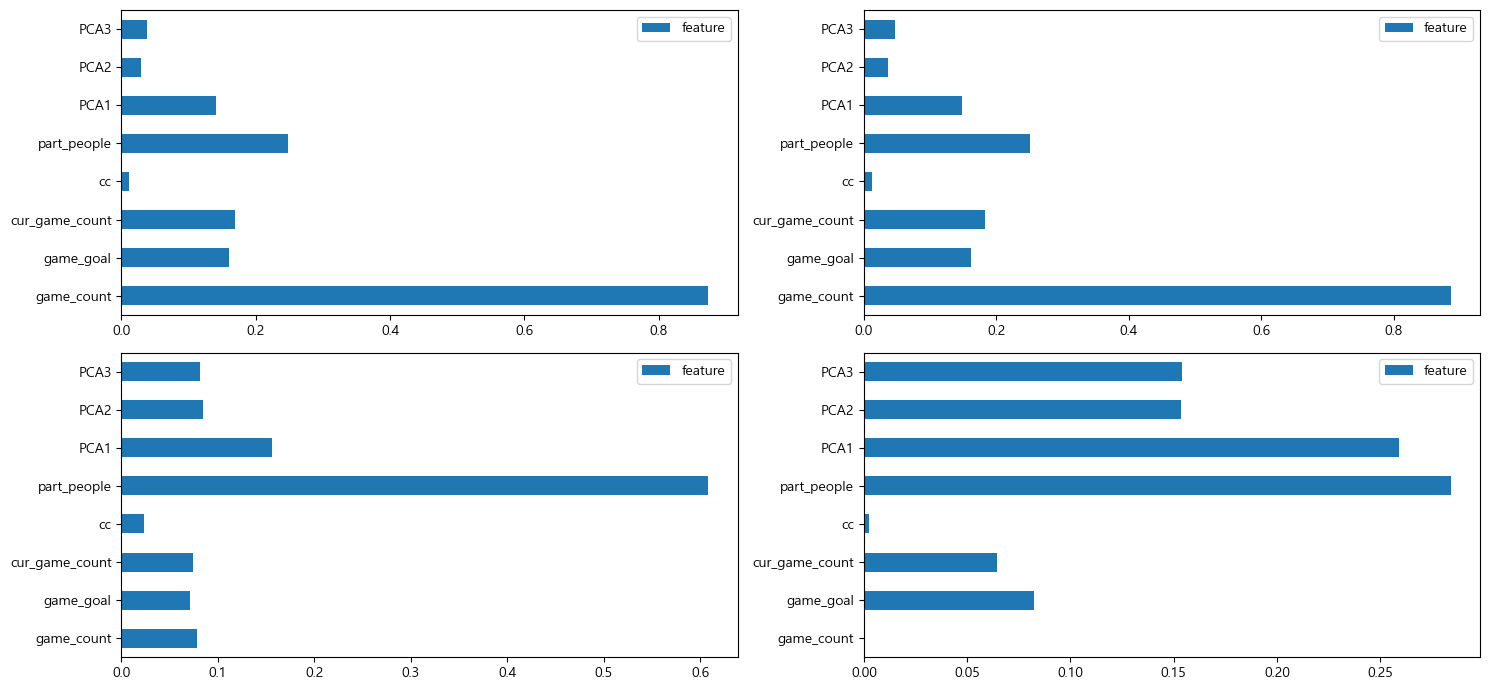

In [286]:
fig, axs = plt.subplots(2, 2, figsize=(15, 7))

pd.DataFrame(abs(*pp_clf_model1.coef_), columns=["feature"]).set_index(
    df_encoded.drop('track_E_encoded', axis=1).columns
).plot.barh(
    ax = axs[0][0],
)

pd.DataFrame(abs(*pp_clf_model2.coef_), columns=["feature"]).set_index(
    df_encoded.drop('track_E_encoded', axis=1).columns
).plot.barh(
    ax = axs[0][1],
)

pd.DataFrame(abs(pp_reg_model1.coef_), columns=["feature"]).set_index(
    df_encoded.drop('track_E_encoded', axis=1).columns
).plot.barh(
    ax = axs[1][0],
)

pd.DataFrame(pp_reg_model2.feature_importances_, columns=["feature"]).set_index(
    df_encoded.drop('track_E_encoded', axis=1).columns
).plot.barh(
    ax = axs[1][1],
)

fig.tight_layout()